In [23]:
import os

import joblib
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, \
    StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.multioutput  import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler
from missforest.missforest import MissForest

In [24]:
df = pd.read_csv('../datasets/output_file_Run_1_labeled.csv', usecols=lambda column: column != 'Raw_Type')
df.head(10)

,pslist_nproc,pslist_nppid,pslist_avg_threads,pslist_nprocs64bit,pslist_avg_handlers,dlllist_ndlls,dlllist_avg_dlls_per_proc,handles_nhandles,handles_avg_handles_per_proc,handles_nport,...,modules_nmodules,svcscan_nservices,svcscan_kernel_drivers,svcscan_fs_drivers,svcscan_process_services,svcscan_shared_process_services,svcscan_interactive_process_services,svcscan_nactive,Label,SubType
0,142,20,1.314789e+01,142,0.0,7190,52.481752,50211,363.847826,0,...,175,1473,750,85,151,2,2,402,Malware,Ransomware
1,153,20,1.031373e+01,153,0.0,7526,52.263889,53017,363.130137,0,...,175,1424,719,85,154,2,2,392,Malware,Ransomware
2,155,17,1.025806e+01,155,0.0,7328,52.342857,52861,357.168919,0,...,175,1474,745,87,159,2,2,391,Malware,Ransomware
3,140,20,1.285714e+01,139,0.0,6825,50.932836,48186,356.933333,0,...,175,1439,729,86,148,2,2,389,Malware,Ransomware
4,144,17,9.875000e+00,143,0.0,6917,51.237037,48019,347.963768,0,...,175,1422,720,87,151,2,2,393,Malware,Ransomware
5,149,16,1.010738e+01,148,0.0,7592,53.843972,50719,354.678322,0,...,175,1437,729,87,152,2,2,390,Malware,Ransomware
6,149,19,2.125126e+07,144,0.0,7123,51.615942,49022,350.157143,0,...,175,1433,728,84,146,2,2,377,Malware,Ransomware
7,140,17,1.113571e+01,138,0.0,6835,50.629630,47382,348.397059,0,...,175,1417,718,85,152,2,2,380,Malware,Ransomware
8,134,16,8.738806e+00,132,0.0,6553,50.407692,44387,338.832061,0,...,175,1420,718,86,152,2,2,377,Malware,Ransomware
9,146,17,1.371233e+01,146,0.0,7494,53.528571,51620,368.714286,0,...,175,1396,705,84,145,2,2,385,Malware,Ransomware


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   pslist_nproc                            360 non-null    int64  
 1   pslist_nppid                            360 non-null    int64  
 2   pslist_avg_threads                      360 non-null    float64
 3   pslist_nprocs64bit                      360 non-null    int64  
 4   pslist_avg_handlers                     360 non-null    float64
 5   dlllist_ndlls                           360 non-null    int64  
 6   dlllist_avg_dlls_per_proc               360 non-null    float64
 7   handles_nhandles                        360 non-null    int64  
 8   handles_avg_handles_per_proc            360 non-null    float64
 9   handles_nport                           360 non-null    int64  
 10  handles_nfile                           360 non-null    int64 

In [26]:
df.describe()

,pslist_nproc,pslist_nppid,pslist_avg_threads,pslist_nprocs64bit,pslist_avg_handlers,dlllist_ndlls,dlllist_avg_dlls_per_proc,handles_nhandles,handles_avg_handles_per_proc,handles_nport,...,callbacks_nanonymous,callbacks_ngeneric,modules_nmodules,svcscan_nservices,svcscan_kernel_drivers,svcscan_fs_drivers,svcscan_process_services,svcscan_shared_process_services,svcscan_interactive_process_services,svcscan_nactive
count,360.000000,360.000000,3.600000e+02,360.000000,360.0,360.000000,360.000000,360.000000,360.000000,360.0,...,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,140.930556,17.944444,1.034095e+06,140.158333,0.0,6926.075000,51.597716,47242.386111,348.735752,0.0,...,217.930556,21.630556,175.338889,1399.505556,709.644444,82.972222,147.822222,1.944444,1.952778,396.644444
std,10.739932,2.106423,5.278176e+06,10.849948,0.0,682.887714,1.792422,7752.285965,48.463485,0.0,...,14.200638,12.815583,1.278334,239.507643,122.034340,14.196563,25.429822,0.329129,0.342843,77.569746
min,82.000000,14.000000,8.442748e+00,80.000000,0.0,3283.000000,43.773333,0.000000,0.000000,0.0,...,29.000000,17.000000,175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,133.000000,17.000000,9.784788e+00,132.000000,0.0,6414.750000,49.948473,43725.000000,342.135246,0.0,...,217.000000,17.000000,175.000000,1417.000000,717.000000,84.000000,148.000000,2.000000,2.000000,383.000000
50%,142.500000,17.000000,1.041643e+01,142.000000,0.0,7027.000000,51.856112,48531.500000,355.238911,0.0,...,217.000000,21.000000,175.000000,1436.000000,726.000000,85.000000,152.000000,2.000000,2.000000,391.000000
75%,148.000000,20.000000,1.295147e+01,147.000000,0.0,7453.750000,53.067661,51303.250000,362.309404,0.0,...,223.000000,25.000000,176.000000,1455.000000,738.000000,86.000000,155.000000,2.000000,2.000000,402.000000
max,163.000000,26.000000,5.249594e+07,160.000000,0.0,8129.000000,55.028571,73744.000000,506.943262,0.0,...,223.000000,252.000000,198.000000,1609.000000,834.000000,96.000000,165.000000,2.000000,3.000000,501.000000


In [27]:
df.describe(include=['object', 'category', 'bool'])

,Label,SubType
count,360,360
unique,2,4
top,Malware,Benign
freq,180,180


In [28]:
info = pd.concat([df.describe(include=np.number), pd.DataFrame(df.dtypes).T. \
                  rename(index={0: 'dtype'}).drop(columns=['SubType', 'Label'])])

In [29]:
info

,pslist_nproc,pslist_nppid,pslist_avg_threads,pslist_nprocs64bit,pslist_avg_handlers,dlllist_ndlls,dlllist_avg_dlls_per_proc,handles_nhandles,handles_avg_handles_per_proc,handles_nport,...,callbacks_nanonymous,callbacks_ngeneric,modules_nmodules,svcscan_nservices,svcscan_kernel_drivers,svcscan_fs_drivers,svcscan_process_services,svcscan_shared_process_services,svcscan_interactive_process_services,svcscan_nactive
count,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,...,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0
mean,140.930556,17.944444,1034094.500053,140.158333,0.0,6926.075,51.597716,47242.386111,348.735752,0.0,...,217.930556,21.630556,175.338889,1399.505556,709.644444,82.972222,147.822222,1.944444,1.952778,396.644444
std,10.739932,2.106423,5278176.081137,10.849948,0.0,682.887714,1.792422,7752.285965,48.463485,0.0,...,14.200638,12.815583,1.278334,239.507643,122.03434,14.196563,25.429822,0.329129,0.342843,77.569746
min,82.0,14.0,8.442748,80.0,0.0,3283.0,43.773333,0.0,0.0,0.0,...,29.0,17.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,133.0,17.0,9.784788,132.0,0.0,6414.75,49.948473,43725.0,342.135246,0.0,...,217.0,17.0,175.0,1417.0,717.0,84.0,148.0,2.0,2.0,383.0
50%,142.5,17.0,10.416426,142.0,0.0,7027.0,51.856112,48531.5,355.238911,0.0,...,217.0,21.0,175.0,1436.0,726.0,85.0,152.0,2.0,2.0,391.0
75%,148.0,20.0,12.951467,147.0,0.0,7453.75,53.067661,51303.25,362.309404,0.0,...,223.0,25.0,176.0,1455.0,738.0,86.0,155.0,2.0,2.0,402.0
max,163.0,26.0,52495940.66129,160.0,0.0,8129.0,55.028571,73744.0,506.943262,0.0,...,223.0,252.0,198.0,1609.0,834.0,96.0,165.0,2.0,3.0,501.0
dtype,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [30]:
df.isna().sum().sum()

np.int64(0)

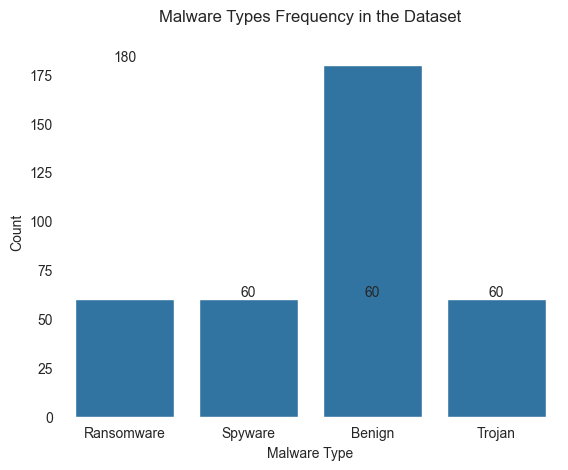

In [31]:
sns.countplot(x=df['SubType'])
counts = df['SubType'].value_counts()
for i, count in enumerate(counts):
    plt.annotate(str(count), (i, count), ha='center', va='bottom')
plt.grid(axis='y')
plt.xlabel('Malware Type')
plt.ylabel('Count')
plt.title('Malware Types Frequency in the Dataset\n')
plt.box(False)
plt.show()

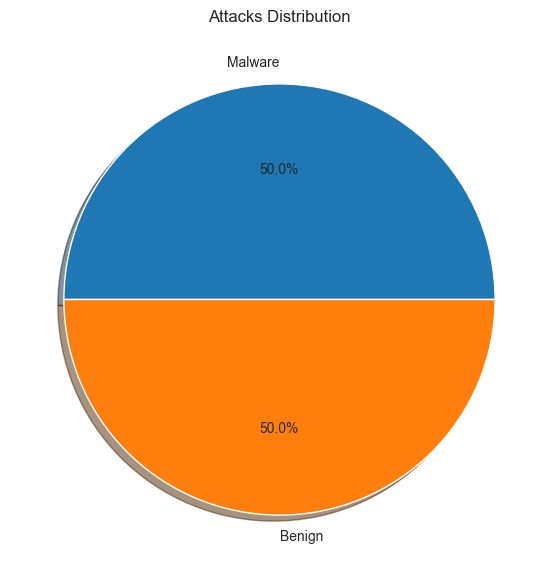

In [32]:
attacks = df['Label'].value_counts()
labels = df['Label'].unique()
plt.figure(figsize=(7, 7))
plt.pie(attacks, labels=labels, 
        autopct='%1.1f%%', shadow=True,
        wedgeprops={'edgecolor': 'white'},)
plt.title('Attacks Distribution')
plt.show()

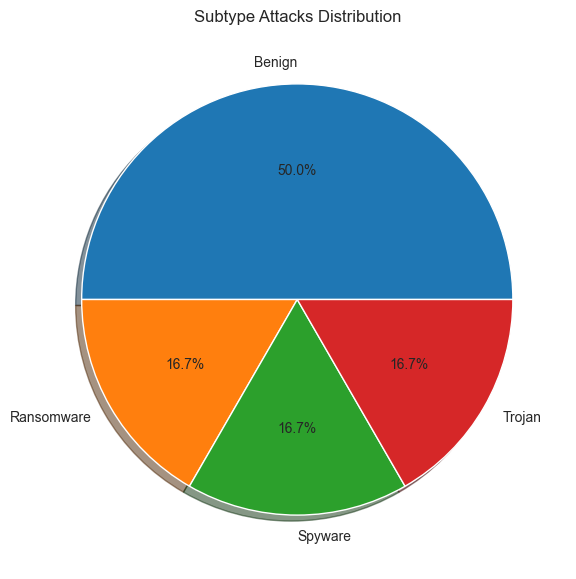

In [33]:
subtype = df['SubType'].value_counts()
labels = ["Benign", "Ransomware", "Spyware", "Trojan",]
plt.figure(figsize=(7, 7))
plt.pie(subtype, labels=labels, 
        autopct='%1.1f%%', shadow=True,
        wedgeprops={'edgecolor': 'white'},)
plt.title('Subtype Attacks Distribution')
plt.show()

In [34]:
df['Label'] = df['Label'].map({'Benign': 0, 'Malware': 1})
df['SubType'] = df['SubType'].map({'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3})

In [35]:
test_size = 0.2
x_train, x_test = train_test_split(df, test_size=test_size, stratify=df[['SubType', 'Label']], random_state=42)

In [36]:
x_train_feats, x_test_feats = x_train.drop(columns=['SubType', 'Label']), x_test.drop(columns=['SubType', 'Label'])
y_train, y_test = x_train[['SubType', 'Label']], x_test[['SubType', 'Label']]

In [37]:
x_train_feats.shape, x_test_feats.shape, y_train.shape, y_test.shape

((288, 55), (72, 55), (288, 2), (72, 2))

In [38]:
##### Imputation fehlende Werte imputieren
mf = MissForest()
x_train_feats_imputed = mf.fit_transform(
    x_train_feats) if x_train_feats.isnull().sum().sum() > 0 else x_train_feats.copy()

In [39]:
##### Normalization
scaler = MinMaxScaler()
x_train_feats_imputed_sc = pd.DataFrame(scaler.fit_transform(x_train_feats_imputed), 
                                        columns=x_train_feats.columns,
                                        index=y_train.index)

In [40]:
x_test_feats_sc = pd.DataFrame(scaler.transform(x_test_feats), columns=x_test_feats.columns, index=y_test.index)

In [41]:
models = [
    RandomForestClassifier(random_state=42),
    MultiOutputClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=30, learning_rate=.01,
                             random_state=42), n_jobs=-1),
    MultiOutputClassifier(LGBMClassifier(random_state=42), n_jobs=-1),
    MultiOutputClassifier(GradientBoostingClassifier(random_state=42), n_jobs=-1),
    MultiOutputClassifier(StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(class_weight='balanced', random_state=42)),
            ('rf', RandomForestClassifier(max_depth=10, random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=RandomForestClassifier(random_state=42),
        cv=3, n_jobs=-1, verbose=1), n_jobs=-1),
    MultiOutputClassifier(GaussianNB(), n_jobs=-1),
    MultiOutputClassifier(SVC(kernel='rbf', probability=True, random_state=42), n_jobs=-1)
]

In [42]:
for i, model in enumerate(models):
    print(f'Training model {i + 1}/{len(models)}: {model.__class__.__name__}')
    model.fit(x_train_feats_imputed_sc, y_train)

Training model 1/7: RandomForestClassifier
Training model 2/7: MultiOutputClassifier
Training model 3/7: MultiOutputClassifier
Training model 4/7: MultiOutputClassifier
Training model 5/7: MultiOutputClassifier
Training model 6/7: MultiOutputClassifier
Training model 7/7: MultiOutputClassifier


In [43]:
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

for i, model in enumerate(models):
    y_test_preds = model.predict(x_test_feats_sc)
    print(f'\n Evaluating model {i + 1}/{len(models)}: {model.__class__.__name__}')
    
    print('SubType Classification Report:\n',
          classification_report(y_test.iloc[:, 0], y_test_preds[:, 0], zero_division=0))
    print('Label Classification Report:\n',
          classification_report(y_test.iloc[:, 1], y_test_preds[:, 1], zero_division=0))

    if isinstance(model, MultiOutputClassifier):
        for label_index, label_name in enumerate(["SubType", "Label"]):
            scores = cross_validate(model.estimators_[label_index], x_train_feats_imputed_sc, 
                                    y_train.iloc[:, label_index], cv=cv_strategy,
                                    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                                    return_estimator=True, n_jobs=-1)

            print(f'\n Cross-Validation Ergebnisse für {label_name}:')
            print(f'Durchschnittliche Accuracy ({cv_folds}-Fold CV): {np.mean(scores["test_accuracy"]):.4f}')
            print(f'Durchschnittliche Präzision ({cv_folds}-Fold CV): {np.mean(scores["test_precision_macro"]):.4f}')
            print(f'Durchschnittlicher Recall ({cv_folds}-Fold CV): {np.mean(scores["test_recall_macro"]):.4f}')
            print(f'Durchschnittlicher F1-Score ({cv_folds}-Fold CV): {np.mean(scores["test_f1_macro"]):.4f}')
    
    else:
        scores = cross_validate(model, x_train_feats_imputed_sc, y_train.iloc[:, 1], cv=cv_strategy,
                                scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                                return_estimator=True, n_jobs=-1)

        print(f'Durchschnittliche Accuracy ({cv_folds}-Fold CV): {np.mean(scores["test_accuracy"]):.4f}')
        print(f'Durchschnittliche Präzision ({cv_folds}-Fold CV): {np.mean(scores["test_precision_macro"]):.4f}')
        print(f'Durchschnittlicher Recall ({cv_folds}-Fold CV): {np.mean(scores["test_recall_macro"]):.4f}')
        print(f'Durchschnittlicher F1-Score ({cv_folds}-Fold CV): {np.mean(scores["test_f1_macro"]):.4f}')


 Evaluating model 1/7: RandomForestClassifier
SubType Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.86      0.70        36
           1       0.29      0.17      0.21        12
           2       0.20      0.17      0.18        12
           3       0.50      0.08      0.14        12

    accuracy                           0.50        72
   macro avg       0.39      0.32      0.31        72
weighted avg       0.46      0.50      0.44        72

Label Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.53      0.58        36
           1       0.60      0.69      0.64        36

    accuracy                           0.61        72
   macro avg       0.61      0.61      0.61        72
weighted avg       0.61      0.61      0.61        72

Durchschnittliche Accuracy (5-Fold CV): 0.7394
Durchschnittliche Präzision (5-Fold CV): 0.7409
Durchschnittlicher Recall (5-Fold 

In [44]:
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

for i, model in enumerate(models):
    base_model_name = model.estimator.__class__.__name__ if isinstance(model, MultiOutputClassifier) else model.__class__.__name__

    model_name = f"{base_model_name}_output_file_Run_1_labeled.pkl"
    model_path = os.path.join(model_dir, model_name)

    # Modell speichern
    joblib.dump(model, model_path)
    print(f"Gespeichert: {model_path}")

Gespeichert: saved_models\RandomForestClassifier_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\AdaBoostClassifier_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\LGBMClassifier_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\GradientBoostingClassifier_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\StackingClassifier_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\GaussianNB_output_file_Run_1_labeled.pkl
Gespeichert: saved_models\SVC_output_file_Run_1_labeled.pkl
